Seq2Seq model is a model that takes a stream of sentences as an input and outputs another stream of sentences. This can be seen in Neural Machine Translation where input sentences is one language and output sentences are translated versions of that language. Encoder and Decoder are the two main techniques used in seq2seq modeling.

Encoder Model: Encoder Model is used to encode or transform the input sentences and generate feedback after every step. This feedback can be an internal state i.e hidden state or cell state if we are using the LSTM layer. Encoder models capture the vital information from the input sentences while maintaining the context throughout.

In Neural Machine translation, our input language will be passed into the encoder model where it will capture the contextual information without modifying the meaning of the input sequence. Outputs from the encoder model are then passed into the decoder model to get the output sequences.

Decoder Model: The decoder model is used to decode or predict the target sentences word by word. Decoder input data takes the input of target sentences and predicts the next word which is then fed into the next layer for the prediction. ‘<start>’ (start of target sentence) and ‘<end>’ (end of target sentence) are the two words that help the model to know what will be the initial variable to predict the next word and the ending variable to know the ending of the sentence. While training the model, we first provide the word ‘<start>’, the model then predicts the next word that is the decoder target data. This word is then fed as input data for the next timestep to get the next word prediction.
    
Input text: Now that I’ve learned about machine learning, I’d like to work on some projects. Can someone recommend the best source for machine learning projects?

Target text: DataFlair is the best source for machine learning projects.

As you can see, we have passed the input text into the model. Rather than focusing on the whole word which is very difficult to remember, we will only focus on specific words for the prediction. In our example, we will only focus on the words like ‘source’, ‘machine learning’ and ‘projects’ to predict the target text.

There are two classes of Attention Mechanisms.

a) Global Attention :
B) Local Attention

Global Attention: In Global attention, all the hidden states of every time step from the encoder model is used to generate the context vector.

Local Attention: In Local attention, some of the hidden states from the encoder model is used to generate the context vector.

In [1]:
from google.colab import files 
files.upload() #upload your kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srchoudhury722k","key":"b236b55c0070e302d33aef7bc72f4868"}'}

In [2]:
!mkdir ~/.kaggle #create a directory called .kaggle in the root folder
!cp kaggle.json ~/.kaggle/ #copy kaggle.json to this folder
!chmod 600 ~/.kaggle/kaggle.json #add full rights to this copied file

In [3]:
!rm kaggle.json #remove the original one

In [4]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 98% 238M/242M [00:05<00:00, 52.5MB/s]
100% 242M/242M [00:05<00:00, 47.2MB/s]


In [5]:
!unzip amazon-fine-food-reviews.zip  #unzip the zip file

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [6]:
!rm amazon-fine-food-reviews.zip #remove the zip file

In [7]:
#DataFlair Project
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
#read the dataset file for text Summarizer
df=pd.read_csv("Reviews.csv",nrows=100000)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
# Check null values
df.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,4
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,2
Text,0


In [10]:
#drop the duplicate and na values from the records
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)
input_data = df.loc[:,'Text']
target_data = df.loc[:,'Summary']

In [11]:
target_data.replace('', np.nan, inplace=True)

In [12]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]
contractions=pickle.load(open("contractions.pkl","rb"))['contractions']
#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

In [13]:
def clean(texts,src):
    #remove the html tags
    texts = BeautifulSoup(texts, "html").text
    #tokenize the text into words 
    words=word_tokenize(texts.lower())
    words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
    #filter words which contains \ 
    #integers or their length is less than or equal to 3
    #contraction file to expand shortened words
    words= [contractions[w] if w in contractions else w for w in words ]
    #stem the words to their root word and filter stop words
    if src=="inputs":
        words= [stemm.stem(w) for w in words if w not in stop_words]
    else:
        words= [w for w in words if w not in stop_words]
    return words
    

In [14]:
#pass the input records and taret records
for in_txt,tr_txt in zip(input_data,target_data):
    in_words= clean(in_txt,"inputs")
    input_texts+= [' '.join(in_words)]
    input_words+= in_words
    #add 'sos' at start and 'eos' at end of text
    tr_words= clean("sos "+tr_txt+" eos","target")
    target_texts+= [' '.join(tr_words)]
    target_words+= tr_words

In [15]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  32131
number of target words :  14157
maximum input length :  74
maximum target length :  17


# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

#Stemming is a technique used to extract the base form of the words by removing affixes from them.
#It is just like cutting down the branches of a tree to its stems.
#For example, the stem of the words eating, eats, eaten is eat.

#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------


def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]
    
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    
    return review

print("Before preprocessing : ")
df.Text.iloc[6]


# apply preprocessing function

df.Text = df.Text.apply(preprocessor) 
print("After preprocessing : ")
df.Text.iloc[6]

In [16]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0) 

In [17]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)

#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train) 

In [18]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')

#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [19]:
latent_dim = 500
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 

In [20]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

In [21]:
# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

In [22]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [23]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax') 
dec_outputs = dec_dense(merge) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 500)      16066000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 74, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

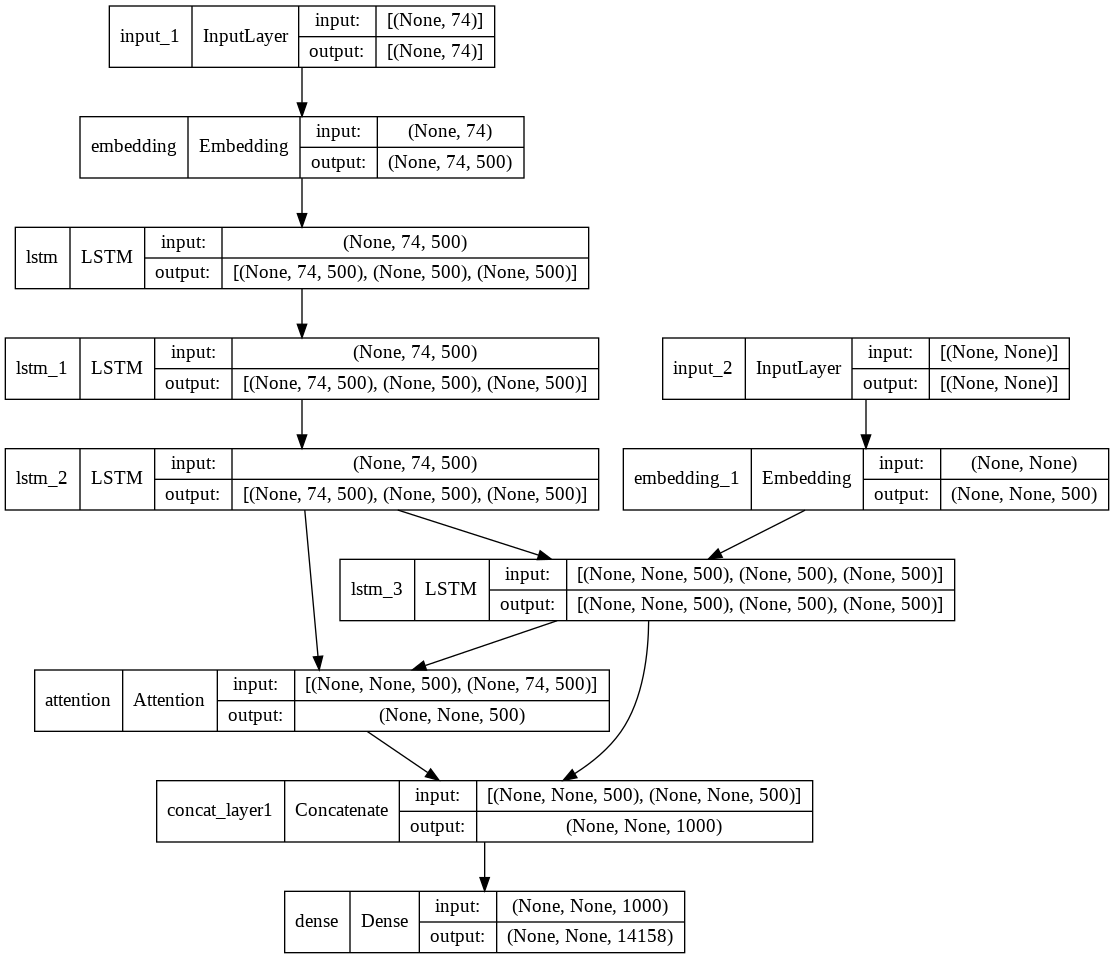

In [24]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
model.compile( optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
model.fit([en_in_data, dec_in_data], dec_tr_data, batch_size=512, epochs=10, validation_split=0.1)

Epoch 1/10
125/125 [==============================] - 198s 1s/step - loss: 1.5327 - accuracy: 0.8114 - val_loss: 1.2804 - val_accuracy: 0.8341
Epoch 2/10
125/125 [==============================] - 185s 1s/step - loss: 1.2427 - accuracy: 0.8341 - val_loss: 1.2055 - val_accuracy: 0.8372
Epoch 3/10
125/125 [==============================] - 184s 1s/step - loss: 1.1712 - accuracy: 0.8369 - val_loss: 1.1645 - val_accuracy: 0.8394
Epoch 4/10
125/125 [==============================] - 185s 1s/step - loss: 1.1169 - accuracy: 0.8390 - val_loss: 1.1344 - val_accuracy: 0.8409
Epoch 5/10
125/125 [==============================] - 184s 1s/step - loss: 1.0732 - accuracy: 0.8409 - val_loss: 1.1165 - val_accuracy: 0.8415
Epoch 6/10
125/125 [==============================] - 184s 1s/step - loss: 1.0347 - accuracy: 0.8427 - val_loss: 1.1006 - val_accuracy: 0.8423
Epoch 7/10
125/125 [==============================] - 184s 1s/step - loss: 0.9990 - accuracy: 0.8445 - val_loss: 1.0945 - val_accuracy: 0.8431

In [27]:
model.save("summarizer_model.h5")

In [28]:
# encoder inference
latent_dim=500

#load the model
model = models.load_model("summarizer_model.h5")
 
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

In [29]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [30]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [31]:
#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0]=' '

In [32]:
def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)

    #target sequence with inital word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']

    #if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition: 
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "

        # Exit condition: either hit max length
        # or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
          stop_condition = True
        
        #update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c
    
    #return the deocded sentence
    return decoded_sentence

In [33]:
inp_review = input("Enter : ")
print("Review :",inp_review)

inp_review = clean(inp_review,"inputs")
inp_review = ' '.join(inp_review)
inp_x= in_tokenizer.texts_to_sequences([inp_review]) 
inp_x= pad_sequences(inp_x,  maxlen=max_in_len, padding='post')

summary=decode_sequence(inp_x.reshape(1,max_in_len))
if 'eos' in summary :
  summary=summary.replace('eos','')
print("\nPredicted summary:",summary);print("\n")

Enter : i love the taste of tea
Review : i love the taste of tea

Predicted summary: great  


